# Spike Calibration
The accuracy of the double spike technique depends crucially on how well the double spike is calibrated. This notebook illustrates one method of calibration which uses measurements of mixtures of the double spike with a known standard material. See Figure 6 of [Klaver and Coath 2019, Geostand. Geoanal. Res.](https://doi.org/10.1111/ggr.12248) and Appendix F of the manuscript for further details.

In [1]:
import doublespike as ds
import numpy as np
import matplotlib.pyplot as plt

As an example we will consider Fe isotopes, with a $^{57}$Fe-$^{58}$Fe double spike.

In [2]:
isodata_fe = ds.IsoData("Fe")
true_spike = [0.0025, 0.1060, 0.4413, 0.4502]

## Monte Carlo simulated data
We will use Monte Carlo simulation to produce some fictious data to use for the calibration. We first measure the pure double spike, taking an average over 100 integrations.

In [3]:
n = 100
spike_measurements = ds.monterun(isodata_fe, 1.0, true_spike, alpha=0.0, beta=0.8, n=n)
spike_measurement = np.mean(spike_measurements, axis=0)
print(spike_measurement)

[0.02382983 1.04017915 4.39233518 4.54365706]


Now we will take a series of mixtures of spike and standard, again averaging over 100 integrations.

In [4]:
mixture_props = [0.3, 0.5, 0.7]
mixture_betas = [2.0, 1.5, 1.7]
mixture_measurements = [
    ds.monterun(isodata_fe, prop, true_spike, alpha=0.0, beta=beta, n=n)
    for prop, beta in zip(mixture_props, mixture_betas)
]
mixture_measurement = [np.mean(m, axis=0) for m in mixture_measurements]
mixture_measurement = np.vstack(mixture_measurement)
print(mixture_measurement)

[[0.38272341 6.65847944 1.50674743 1.45205632]
 [0.28380651 5.0328508  2.33539185 2.34797347]
 [0.17637531 3.39969452 3.16088875 3.26305085]]


## Performing the calibration
We now perform the calibration using both the pure spike measurement and the spike-standard mixture measurements as input. The calibration routine minimises the chi-squared misfit between data and model-predicted isotopic ratios, i.e. minimising

$$ \chi^2 = \sum (\mathbf{m}_\text{obs} - \mathbf{m}_\text{model})^T \; \mathbf{W}\; (\mathbf{m}_\text{obs} - \mathbf{m}_\text{model}) $$
where the weight matrix $\mathbf{W}$ is chosen as the inverse of the expected covariance matrix for `errormodel['measured']`. It may be possible to improve the calibration by adjusting the weighting to be more appropriate for the data of interest.

The calibration routine returns the composition of the calibrated spike, estimates of the mixing proportions of spike and standard, the instrumental fractionation factors for both the spike measurements and the spike-standard mixture measurements, the chi-squared misfit, and the degrees of freedom for the chi-squared statistic. 

In [5]:
cal = ds.spike_calibration(isodata_fe, spike_measurement, mixture_measurement)
print(cal)

{'calibrated_spike': array([0.00250002, 0.10600085, 0.44130018, 0.45019895]), 'prop_mixture': [0.300000764129837, 0.5000000274237444, 0.7000021519071813], 'beta_mixture': array([2.00001085, 1.49999473, 1.69989461]), 'beta_spike': array([0.80041034]), 'misfit': 0.013707250567584737, 'df': 2}


Since in this example we know the true composition of the spike, we can see how well the calibration routine has recovered the true composition of the spike:

In [6]:
calibrated_spike = cal["calibrated_spike"]
print("True spike:", true_spike)
print("Calibrated spike:", calibrated_spike)
print("Difference:", calibrated_spike - true_spike)

True spike: [0.0025, 0.106, 0.4413, 0.4502]
Calibrated spike: [0.00250002 0.10600085 0.44130018 0.45019895]
Difference: [ 2.11636760e-08  8.49068513e-07  1.78117189e-07 -1.04834938e-06]


# Validation of the calibration
One way of checking the calibration is to run the double spike inversion on data produced from a series of mixtures of spike and standard in different proportions. Here we use Monte Carlo simulation to produce more fictious data for a series of such mixtures

In [7]:
n = 1000
mixture_props = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
mixture_betas = 1.1 * np.ones_like(mixture_props)
measured = [
    ds.monterun(isodata_fe, prop, true_spike, alpha=0.0, beta=beta, n=n)
    for prop, beta in zip(mixture_props, mixture_betas)
]

Now we run this fictious data through the double spike inversion to estimate the natural fractionation factor $\alpha$. The true value of $\alpha$ should be zero as we are measuring mixtures of the standard and the spike.

In [8]:
data = [ds.dsinversion(isodata_fe, m, calibrated_spike) for m in measured]
alpha = [np.mean(d["alpha"]) for d in data]
prop = [np.mean(d["prop"]) for d in data]
alpha_err = [np.std(d["alpha"]) for d in data]
print(alpha)

[0.00026161827970858553, 9.780590101979544e-05, 8.761077848548851e-05, 7.224993386801511e-05, 0.00012707427804734892, 6.668255672932258e-05, -9.313806538432102e-05, 0.00023519598247875235, 0.0003340033239492854]


We can plot the recovered $\alpha$ values as a function of the proportion of spike in the mixture. Here there is no systematic trend in mean $\alpha$ with proportion of spike. One way of identifying a poorly-calibrated double spike is to see a systematic variation of $\alpha$ with proportion of spike in the mixture.

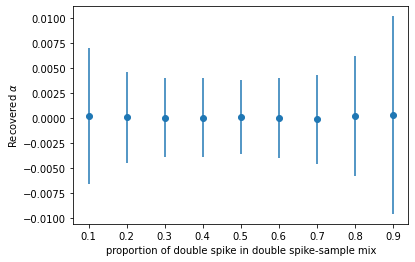

In [9]:
plt.errorbar(prop, alpha, yerr=alpha_err, fmt="o")
plt.xlabel("proportion of double spike in double spike-sample mix")
plt.ylabel(r"Recovered $\alpha$");

We can also compare the errors in $\alpha$ obtained from the inversion with those expected from the linear error propagation. In this case we have an excellent match as the Monte-Carlo simulations are based on exactly the same error model as the linear error propagation.

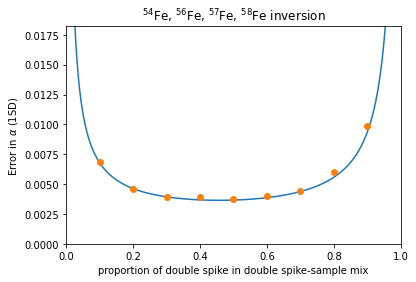

In [10]:
ds.errorcurve(isodata_fe, calibrated_spike)
plt.plot(prop, alpha_err, "o");